In [8]:

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score, precision_score, accuracy_score, classification_report
# os.chdir('..')

%pwd


'c:\\Users\\larakim\\Documents\\Data_train\\Satellite_image_classif\\ML-pipeline-Satellite-image-classification'

In [13]:
import keras
import tensorflow as tf

directory = 'artifacts/data_ingestion/data/'
# classes = ['green_area', 'water', 'desert', 'cloudy']

# Initialize the ImageDataGenerator (here, we're just rescaling the images)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
    validation_split=0.2) 

ds_train = train_datagen.flow_from_directory(
    directory,
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    seed=10,
    subset='training',
    interpolation="nearest",
    target_size=(150, 150),
)
ds_val = train_datagen.flow_from_directory(
    directory,
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    seed=10,
    subset='validation',
    interpolation="nearest",
    target_size=(150, 150),
)
labels = dict((v,k) for k,v in (ds_val.class_indices).items())

print ("In train_generator ")
for i in range(len (ds_train.class_indices)):
    print(labels[i],":\t",list(ds_train.classes).count(i))
print ("") 

print ("In validation_generator ")
for i in range(len (ds_val.class_indices)):
    print(labels[i],":\t",list(ds_val.classes).count(i))
print ("") 

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.
In train_generator 
cloudy :	 1200
desert :	 905
green_area :	 1200
water :	 1200

In validation_generator 
cloudy :	 300
desert :	 226
green_area :	 300
water :	 300



In [73]:
# Fetch a batch of images and labels
images, labels = next(ds_train)

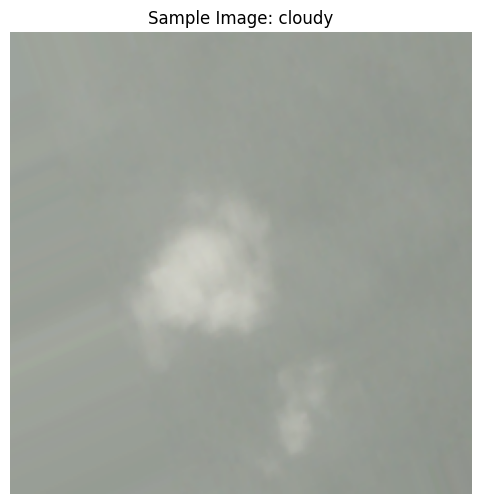

In [28]:
# Convert the one-hot encoded labels to the class index (integer)
class_indices = np.argmax(labels, axis=1)

# Get the class labels (names) from the generator
class_labels = list(ds_train.class_indices.keys())

# Plot the first image in the batch
plt.figure(figsize=(6, 6))
plt.imshow(images[0].astype(int))
plt.title(f"Sample Image: {class_labels[class_indices[0]]}")
plt.axis('off')  # Hide the axis
plt.show()

In [50]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x,training=False)  
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
predictions = keras.layers.Dense(4,activation='softmax')(x)

# Create the model
model = keras.Model(inputs,predictions)

# Print the model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 8196      
                                                           

In [51]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [52]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

# EarlyStopping to stop training when the validation loss has not improved after 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# ReduceLROnPlateau to reduce the learning rate when the validation loss has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', min_lr=0.00001)


In [53]:
ds_train.reset()
ds_val.reset()

# Fit the model
history = model.fit(
    ds_train,
    epochs=1,  # Adjust based on your needs
    validation_data=ds_val,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

135/141 [===========================>..] - ETA: 5s - loss: 1.1058 - accuracy: 0.6569

KeyboardInterrupt: 

In [56]:
labels = (ds_val.class_indices)
labels

{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}

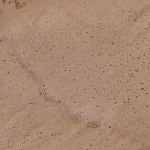

In [18]:
image_path = 'artifacts/data_ingestion/data/desert/desert(8).jpg'
image = keras.utils.load_img(image_path,interpolation="nearest",
    target_size=(150, 150))
input_arr = keras.utils.img_to_array(image)
image

In [10]:
labels = dict((v,k) for k,v in (ds_val.class_indices).items())
labels

{0: 'cloudy', 1: 'desert', 2: 'green_area', 3: 'water'}

In [17]:
# model2.save('dfsdf.keras')

In [54]:
model2 = tf.keras.models.load_model('best_model.h5')
predicted_class = labels[np.argmax(model2.predict(input_arr.reshape(1,150, 150, 3)))]
predicted_class

1/1 [==============================] - 1s 950ms/step


'desert'

In [56]:
predictions = model.predict(ds_val, verbose = 1)

36/36 [==============================] - 35s 957ms/step


In [57]:
predicted_class_indices=np.argmax(predictions,axis=1)
predictedLables= [labels[k] for k in predicted_class_indices]
actualLables= [labels[k] for k in ds_val.classes]


accuracy_score(actualLables, predictedLables)

0.7557726465364121

In [58]:
print(classification_report(actualLables, predictedLables))

              precision    recall  f1-score   support

      cloudy       0.99      0.48      0.64       300
      desert       0.86      0.79      0.82       226
  green_area       0.79      0.91      0.85       300
       water       0.60      0.86      0.71       300

    accuracy                           0.76      1126
   macro avg       0.81      0.76      0.75      1126
weighted avg       0.81      0.76      0.75      1126



In [80]:
cr = classification_report(actualLables, predictedLables, output_dict=True)
di = cr['weighted avg']
di['accuracy'] = cr['accuracy']
di

{'precision': 0.806998501732054,
 'recall': 0.7557726465364121,
 'f1-score': 0.7496775062715,
 'support': 1126.0,
 'accuracy': 0.7557726465364121}

In [68]:
list(ds_val.classes)
predicted_class_indices=np.argmax(predictions,axis=1)
predicted_class_indices



array([0, 2, 3, ..., 3, 3, 2], dtype=int64)

In [73]:
# Calculate precision
precision_metric = tf.keras.metrics.Precision()
precision_metric.update_state(list(ds_val.classes), predicted_class_indices)
precision_metric.result().numpy()

0.8401222

In [80]:
img,c = ds_val.next()

In [84]:
model.predict(ds_val)

 2/36 [>.............................] - ETA: 1:29

KeyboardInterrupt: 

In [ ]:
class_labels = list(ds_train.class_indices.keys())

In [ ]:
import keras

directory = 'artifacts/data_ingestion/data'

ds = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",  #categorical
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=10,
    validation_split=0.3,
    subset='training',
    interpolation="bilinear",
)

In [278]:
ds2 = ds.unbatch()

AttributeError: 'DirectoryIterator' object has no attribute 'unbatch'

In [264]:
images = list(ds2.map(lambda x,y:x))
labels = list(ds2.map(lambda x,y:y))

In [265]:
len(list(images))

5068

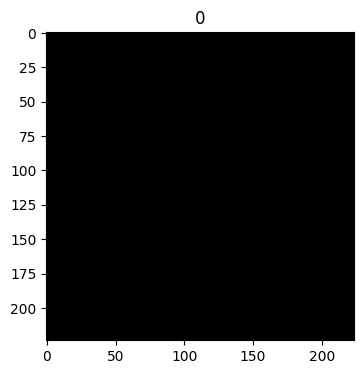

In [270]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

i= 55

imgg = images[i]

plt.figure(figsize=(4,4))
plt.imshow(tf.cast(imgg, tf.int64))
plt.title(labels[i].numpy())
plt.show()

In [267]:
images[i]

<tf.Tensor: shape=(224, 224, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>

In [159]:
set([labels[k].numpy() for k in range(len(labels))])

{0, 1, 2, 3}

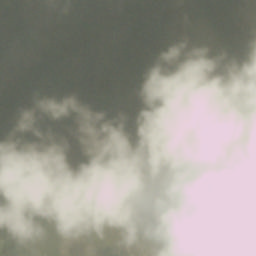

In [260]:
keras.utils.load_img(
    'artifacts/data_ingestion/data/cloudy/train_12.jpg',
    color_mode="rgb",
    target_size=None,
    interpolation="nearest",
    keep_aspect_ratio=False,
)

Found 5631 files belonging to 4 classes.


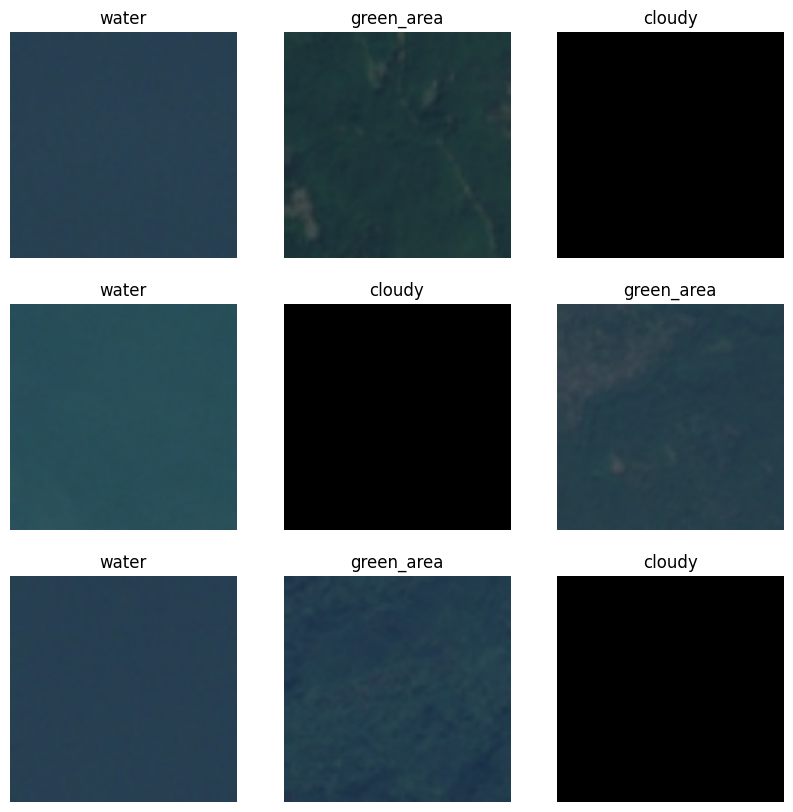

In [261]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('artifacts/data_ingestion/data',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))


class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [4]:
x = (150,150,3)
x[0:2]

(150, 150)